In [ ]:
import torchvision
import torch
import torchvision.transforms as transforms
import random
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset
from collections import Counter
from collections import defaultdict
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter
from collections import OrderedDict
import torch.nn as nn
import time
import os
import torch
import copy
import torch.nn.functional as F
import wandb
import json
import heapq
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np



# Seeds for reproducibility
def set_seeds(seed: int = 123):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
""" PLOT SETTINGS """

plt.style.use("seaborn-v0_8")
plt.rcParams.update({
    "font.size": 18,            # base font size
    "axes.titlesize": 24,       # axis titles
    "axes.labelsize": 22,       # axis labels
    "xtick.labelsize": 18,      # X axis numbers
    "ytick.labelsize": 18,      # Y axis numbers
    "legend.fontsize": 18,      # legend text
    "lines.linewidth": 3.0      # line thickness
})


In [ ]:
# --- Define DINOWithHead ---
class DINOWithHead(nn.Module):
    def __init__(self, backbone, num_classes=100, p=None):
        super().__init__()
        self.backbone = backbone
        layers = []
        if p is not None:
            layers.append(nn.Dropout(p=p))
        layers.append(nn.Linear(384, num_classes))
        self.head = nn.Sequential(*layers)

    def forward(self, x):
        features = self.backbone(x)
        out = self.head(features)
        return out

## Data import and loader creation

In [ ]:
""" DATASET DOWNLOAD """
ROOT = './data'
BATCH_SIZE=64
#BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

tot_train_data = torchvision.datasets.CIFAR100(root=ROOT, train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.CIFAR100(root=ROOT, train=False, download=True, transform=torchvision.transforms.ToTensor())





""" SPLIT TOT_TRAININ in VALIDATION and TRAIN """

def split_dataset(tot_train_data, valid_ratio=0.8):
    """
    Splits the given dataset randomly into training and validation subsets
    """
    train_size = int(valid_ratio * len(tot_train_data))
    val_size = len(tot_train_data) - train_size
    train_data, val_data = random_split(tot_train_data, [train_size, val_size])
    return train_data, val_data

train_data, val_data = split_dataset(tot_train_data, valid_ratio=0.8)



""" DATA TRANSFORMATION """

def data_trasform(dataset, data_augmentation=False):   ### train_data or tot_train_data
    """
    Returns train and val/test transforms based on dataset stats.
    Dataset (for computing mean and std) can be either training only or combined train+validation.

    If data_augmentation=True, applies augmentation on training transforms, otherwise only resize and normalize.
    """

    # MEAN and VARIANCE (considering 3 channels)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_samples = 0

    for img, _ in dataset:
        img = img.view(3, -1)  # Flatten H*W
        mean += img.mean(1)
        std += img.std(1)
        nb_samples += 1

    mean /= nb_samples
    std /= nb_samples


    if data_augmentation:
        train_transforms = transforms.Compose([
            transforms.Resize(64, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.RandomCrop(64, padding=4),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.RandAugment(num_ops=2, magnitude=9),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    else:
        train_transforms = transforms.Compose([
            transforms.Resize(64, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    ### NO DATA AUGMENTATION!
    val_test_transforms = transforms.Compose([
        transforms.Resize(64),                    # Resize
        transforms.ToTensor(),                     # Convert to tensor
        transforms.Normalize(mean=mean, std=std)   # Normalization using the training statistics
    ])


    return train_transforms, val_test_transforms






""" DATA TRANSFORMATION and LOADERS """

### ===== For hyperparameter tuning considering train_data and val_data =====
train_transforms, val_test_transforms = data_trasform(train_data)

train_data.dataset.transform = train_transforms
val_data.dataset.transform = val_test_transforms

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



### ===== For model testing considering tot_train_data and test_data =====
train_transforms, val_test_transforms = data_trasform(tot_train_data)

tot_train_data = torchvision.datasets.CIFAR100(root=ROOT, train=True, download=False, transform=train_transforms)
test_data = torchvision.datasets.CIFAR100(root=ROOT, train=False, download=False, transform=val_test_transforms)

tot_train_loader = DataLoader(tot_train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

## Functions Client

In [ ]:
""" SPLIT INTO K CLIENTS: iid and non-iid distributions  """

def iid_shard(dataset, K):
    """
    Splits the dataset into K disjoint subsets (one per client) in an IID fashion. Each client receives ~len(dataset)/K samples,
    drawn uniformly at random across all classes.
    """
    num_items_per_client = len(dataset) // K
    remainder = len(dataset) % K
    all_indices = list(range(len(dataset)))
    random.shuffle(all_indices)

    client_data = {}  # Creation of a dictionary for clients
    start = 0
    for i in range(K):
        # give +1 to the first `remainder` clients
        add = num_items_per_client + (1 if i < remainder else 0)
        end = start + add
        client_data[i+1] = Subset(dataset, all_indices[start:end])
        start = end

    return client_data


def noniid_shard(dataset, K, Nc):
    """
    Splits the dataset into K disjoint subsets (one per client) in a non-IID fashion.
    Disjoint dataset: each sample must belong to exactly one client and cannot be duplicated.
    Nc: each client receives samples from Nc distinct classes, to simulate variability of data across clients.
    """
    # === Feasibility check ===
    all_classes = set(label for _, label in dataset)
    num_classes = len(all_classes)
    if Nc > num_classes:
        raise ValueError(f"Cannot assign {Nc} classes per client: only {num_classes} classes available.")


    # === Step 1: Organize data by class ===
    # This ensures we can select samples from specific classes without duplication.
    label_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        label_to_indices[label].append(idx)    # key: class, value: list of idxs of the corresponding class

    # === Step 2: Shuffle samples within each class ===
    # Prevents consecutive samples from going to the same clients repeatedly.
    for cls in label_to_indices:
        random.shuffle(label_to_indices[cls])

    # === Step 3: Prepare the list of clients and shuffle it ===
    # Guarantees random assignment of classes to clients.
    all_classes = list(label_to_indices.keys())

    client_class_map = {}
    for client_id in range(1, K+1):        # Pre-select Nc classes per client at the beginning.
        client_class_map[client_id] = random.sample(all_classes, Nc)

    client_data = {cid: [] for cid in range(1, K+1)}    # Initialize empty client datasets
    class_to_clients = defaultdict(list)     # For each class, keep track of clients that have it (reverse map from class → clients that have that class)
    for cid, classes in client_class_map.items():
        for cls in classes:
            class_to_clients[cls].append(cid)


    # === Step 4: Distribute samples in rounds ===
    # Distributing samples to clients in rounds
    for cls, indices in label_to_indices.items():    # Iterate over all classes, where indices is the list of the samples for the considered class
        clients = class_to_clients[cls]  # clients that want this class
        if not clients:
            continue
        i = 0
        while indices:
            client_id = clients[i % len(clients)]  # cycling continuously through the list of clients
            sample = indices.pop()                 # take one sample and it removes it so it will not be repeated
            client_data[client_id].append(sample)  # assign to this client
            i += 1

     # === Step 5: Convert sample index lists into Subsets ===
    for cid in client_data:
        client_data[cid] = Subset(dataset, client_data[cid])

    return client_data

## Class Client

In [ ]:
def compress_mask(mask_dict):
    """
    Convert each 0/1 tensor in the mask into a compressed bit array.
    Returns a dictionary: {param_name: (packed_uint8_array, original_shape)}
    """
    compressed = {}
    for name, tensor in mask_dict.items():
        # Move tensor to CPU, cast to uint8, flatten, and convert to numpy
        arr = tensor.detach().to('cpu').to(torch.uint8).contiguous().view(-1).numpy()
        # Pack bits into a compact representation (8x smaller than uint8)
        packed = np.packbits(arr)
        compressed[name] = (packed, tuple(tensor.shape))  # store packed data + original shape
    return compressed


def decompress_mask(compressed_dict):
    """
    Reconstruct torch.uint8 tensors with the original shape (0/1 values).
    """
    mask = {}
    for name, (packed, shape) in compressed_dict.items():
        total = int(np.prod(shape))  # number of elements in original tensor
        # Unpack bits back to 0/1 and trim extra padding
        unpacked = np.unpackbits(packed)[:total]
        # Reshape to original tensor shape and convert to torch.uint8
        mask[name] = torch.from_numpy(unpacked.reshape(shape)).to(torch.uint8)
    return mask



""" CLASS CLIENT"""
class Client:
    def __init__(self, client_id, dataset, loader,
                 mask=None, extra_mask=None, fisher_scores=None,
                 local_weights=None, compressed_mask=None):
        self.client_id = client_id
        self.dataset = dataset
        self.loader = loader

        # Full mask in RAM (0/1 tensors) – only needed during training
        self.mask = mask

        # Lightweight storage version (bit-packed mask)
        self.compressed_mask = compressed_mask

        # Optional: additional mask (depends on your logic)
        self.extra_mask = extra_mask

        # Fisher scores are only needed during calibration;
        # after that, you can set them to None to save memory
        self.fisher_scores = fisher_scores

        # Local weights are not really used in your training loop;
        # kept here only for compatibility
        self.local_weights = local_weights

    def compress_mask(self):
        """
        Compress self.mask into self.compressed_mask and free RAM
        """
        if self.mask is not None:
            # Make sure mask tensors are uint8 (0/1 values)
            self.mask = {k: v.to(torch.uint8) for k, v in self.mask.items()}
            self.compressed_mask = compress_mask(self.mask)
            self.mask = None  # release memory

    def decompress_mask(self):
        """
        Rebuild self.mask (0/1 tensors) from self.compressed_mask
        """
        if self.compressed_mask is not None and self.mask is None:
            self.mask = decompress_mask(self.compressed_mask)



    def num_samples(self):
        """
        Returns the number of samples in the client’s local dataset.
        """
        return len(self.dataset)

    @staticmethod
    def print_samples(clients):
        """
        Prints the number of samples each client holds.
        """
        print("Number of samples per client:")
        for client in clients:
            print(f"Client {client.client_id}: {client.num_samples()} samples")

    @staticmethod
    def plot_class_distribution(clients, dataset):
        """
        Plots the distribution of classes for a list of clients.
        """
        class_distributions = []

        if hasattr(dataset, 'targets'):
            get_label = lambda idx: dataset.targets[idx]
        elif hasattr(dataset, 'labels'):
            get_label = lambda idx: dataset.labels[idx]
        else:
            get_label = lambda idx: dataset[idx][1]

        for client in clients:
            indices = client.loader.dataset.indices if isinstance(client.loader.dataset, Subset) else list(range(len(client.loader.dataset)))
            labels = [get_label(i) for i in indices]
            class_counts = Counter(labels)
            class_distributions.append(class_counts)

        fig, axes = plt.subplots(nrows=1, ncols=len(clients), figsize=(5 * len(clients), 4))
        if len(clients) == 1:
            axes = [axes]

        for i, (client, class_counts) in enumerate(zip(clients, class_distributions)):
            axes[i].bar(class_counts.keys(), class_counts.values(), color='orange')
            axes[i].set_title(f'Client {client.client_id}')
            axes[i].set_xlabel('Classes')
            axes[i].set_ylabel('Frequency')
            axes[i].set_xticks(list(class_counts.keys()))

        plt.tight_layout()
        plt.show()



""" CLIENT CREATION """
def create_clients(data, K, Nc=None, flag = "iid"):   ### data is either train_data or tot_data
    """
    Splits the dataset into K subsets, either IID or non-IID, and returns both the client datasets and their corresponding DataLoaders
    """
    if flag == "iid":     # We want iid
      client_datasets = iid_shard(data, K)     # Split the training data into K clients

    else:    # We want non iid
      client_datasets = noniid_shard(data, K, Nc)

    client_loaders = {}    ### Creation of a DataLoader for each client

    for client_id, subset in client_datasets.items():
        loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)
        client_loaders[client_id] = loader       # The clients id are the indices+1
    return client_datasets, client_loaders


def create_client_objects(data, K, Nc=None, flag="iid", batch_size=64, verbose=True):
    """
    Creates and returns a list of Client objects, each containing its own dataset and DataLoader, ready for use in federated learning
    """

    # === CHECK ===
    if flag == "non-iid" and Nc is None:
        raise ValueError("Nc must be set when flag='non-iid'")

    client_datasets, client_loaders = create_clients(data, K, Nc, flag=flag)
    clients = []
    for client_id in client_datasets.keys():
        clients.append(Client(client_id, client_datasets[client_id], client_loaders[client_id]))


    if verbose:
        print("Clients and their sample sizes:")
        for client in clients:
            print(f"Client {client.client_id}: {client.num_samples()} samples")

    return clients


## Server model evaluation

In [ ]:
""" MODEL EVALUATION """
def evaluate_model(model, data_loader, criterion):
    """
    The evaluate_model function computes the average loss and accuracy of a model on a dataset without updating its weights.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_corrects += torch.sum(preds == labels.data)

    avg_loss = total_loss / len(data_loader.dataset)
    avg_acc = total_corrects.double() / len(data_loader.dataset)

    return avg_loss, avg_acc.item()



In [ ]:
""" CHECKPOINT FUNCTION """
def save_checkpoint(model, epoch, train_losses, train_accuracies,
                    val_test_losses, val_test_accuracies, best_acc, best_loss, best_model_wts, path):
    """
    The save_checkpoint function saves the model’s state, training/validation metrics,
    and best performance to a specified file path.
    """
    dir_name = os.path.dirname(path)
    if dir_name:
        os.makedirs(dir_name, exist_ok=True)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_test_losses': val_test_losses,
        'val_test_accuracies': val_test_accuracies,
        'best_acc': best_acc,
        'best_loss': best_loss,
        'best_model_state_dict': best_model_wts
    }
    torch.save(checkpoint, path)



def init_checkpoint(model, path=None, device='cpu', verbose = True):
    """
    Initialize a checkpoint. If path is None, create default checkpoint with empty/default values.
    If path is given and file exists, load it.
    Returns: start_epoch, best_acc, best_loss, train_losses, train_accuracies, val_test_losses, val_test_accuracies, checkpoint_path, best_model_wts
    """
    if path is None:
        # default path
        os.makedirs("checkpoints", exist_ok=True)
        path = "checkpoints/latest.pth"
        if verbose:
            print(f"Initializing new checkpoint at {path}")
        # save default empty checkpoint
        checkpoint = {
            'epoch': 1,
            'best_acc': 0.0,
            'best_loss': 1e10,
            'train_losses': [],
            'train_accuracies': [],
            'val_test_losses': [],
            'val_test_accuracies': [],
            'model_state_dict': model.state_dict(),
            'best_model_state_dict': copy.deepcopy(model.state_dict())
        }
        torch.save(checkpoint, path)
        return 1, 0.0, 1e10, [], [], [], [], path, copy.deepcopy(model.state_dict())

    else:
        # load existing checkpoint
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Checkpoint file {path} does not exist.")

        print(f"Loading checkpoint from {path}")
        checkpoint = torch.load(path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = checkpoint.get('best_model_state_dict', copy.deepcopy(model.state_dict()))
        return (checkpoint['epoch'],
                checkpoint.get('best_acc', 0.0),
                checkpoint.get('best_loss', 1e10),
                checkpoint.get('train_losses', []),
                checkpoint.get('train_accuracies', []),
                checkpoint.get('val_test_losses', []),
                checkpoint.get('val_test_accuracies', []),
                path,
                best_model_wts )



## Train client

In [ ]:
""" TRAINING FUNCTION """
def train_model_client(model, criterion, optimizer, scheduler, client: Client, J=5, device=None):    ### Single client
    """
    Trains a model locally on a single client for J epochs.
    Performs forward pass, computes loss, backpropagation, and updates weights using the given optimizer.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_loader = client.loader

    # ========== TRAINING ==========
    for j in range(J):   # "inner" loop
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels).item()

        if scheduler is not None:
            scheduler.step()

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_corrects / len(train_loader.dataset)

    return epoch_train_loss, epoch_train_acc    # Return the last performances


## Mask & Fine tuning

In [ ]:
""" MASK COMPUTATION & CALIBRATION """

def compute_fisher_scores(client, model, device):
    """
    Compute diagonal Fisher Information scores for a client using client.loader.
    Stores results in client.fisher_scores.
    """
    model.eval()  # set model to evaluation mode

    # Initialize Fisher scores if not already present
    if not hasattr(client, 'fisher_scores') or client.fisher_scores is None:
        client.fisher_scores = {
            name: torch.zeros_like(param, device="cpu")
            for name, param in model.named_parameters() if param.requires_grad
        }

    num_batches = 0  # counter for normalization

    # Iterate over client data
    for inputs, labels in client.loader:
        num_batches += 1
        inputs, labels = inputs.to(device), labels.to(device)

        model.zero_grad()  # reset gradients
        outputs = model(inputs)

        # Compute log-probabilities
        log_probs = F.log_softmax(outputs, dim=1)

        # Sample labels from the predicted distribution: y ~ p(y|x)
        sampled_y = torch.multinomial(log_probs.exp(), num_samples=1).squeeze(-1)

        # Compute NLL loss on sampled labels and backpropagate
        loss = F.nll_loss(log_probs, sampled_y, reduction="mean")
        loss.backward()

        # Accumulate squared gradients for each parameter
        for name, param in model.named_parameters():
            if param.grad is not None:
                client.fisher_scores[name] += param.grad.detach().cpu() ** 2

    # Normalize Fisher scores by number of batches
    for name in client.fisher_scores.keys():
        client.fisher_scores[name] /= num_batches




def calibrate_mask_for_client(client, model, device, R=5, final_sparsity=0.9, lr=0.005, weight_decay=0.00005 , keep="least"):
    # Initial mask: all ones (uint8), only for trainable parameters
    mask = {name: torch.ones_like(param, device="cpu", dtype=torch.uint8)
            for name, param in model.named_parameters() if param.requires_grad}
    client.mask = mask  # stored in RAM

    # Recompute Fisher scores and update the mask R times
    for r in range(1, R + 1):
        current_density = (1 - final_sparsity) ** (r / R)
        current_sparsity = 1 - current_density
        print(f"[Round = {r}] Sparsity = {current_sparsity:.4f}")

        compute_fisher_scores(client, model, device)
        fisher_scores = client.fisher_scores  # dict {name: tensor(float)}

        #  Flatten all Fisher scores into a single vector
        all_scores = torch.cat([score.view(-1) for score in fisher_scores.values()])

        # --- Compute global threshold using top-k ---
        num_keep_global = int(len(all_scores) * current_density)
        num_keep_global = max(1, min(num_keep_global, len(all_scores)))

        if keep == "least":
            # keep the least important weights
            _, idx = torch.topk(all_scores, k=num_keep_global, largest=False)
        elif keep == "most":
            # keep the most important weights
            _, idx = torch.topk(all_scores, k=num_keep_global, largest=True)
        elif keep == "random":
            # keep random weights
            idx = torch.randperm(len(all_scores))[:num_keep_global]
        else:
            raise ValueError("keep must be 'least', 'most', or 'random'")

        # build global_keep mask
        global_keep = torch.zeros_like(all_scores, dtype=torch.bool)
        global_keep[idx] = True

        # --- Redistribute the threshold layer by layer ---
        new_mask = {}
        start = 0
        for name, score in fisher_scores.items():
            numel = score.numel()
            keep_tensor = global_keep[start:start+numel].view_as(score)
            new_mask[name] = (keep_tensor.to(torch.uint8) * client.mask[name])
            start += numel

        # update the current mask
        client.mask = new_mask
        total_ones = sum(mask.sum().item() for mask in client.mask.values())
        total_params = sum(mask.numel() for mask in client.mask.values())
        perc_active = 100 * total_ones / total_params
        print(f"Active parameters: {total_ones}/{total_params} ({perc_active:.2f}%)")

        # mini-training with SparseSGD + current mask
        param_to_name = {id(param): n for n, param in model.named_parameters()}
        optimizer = SparseSGD(model.parameters(), lr=lr, weight_decay=weight_decay, mask_dict=client.mask, param_to_name=param_to_name)
        local_model = copy.deepcopy(model).to(device)
        train_model_client(local_model, criterion=nn.CrossEntropyLoss(), optimizer=optimizer,
                           scheduler=None, client=client, J=1, device=device)

    # End of calibration: discard Fisher scores to save memory
    client.fisher_scores = None

    # Compress the mask for lightweight storage
    client.compress_mask()




def calibrate_all_clients(clients, global_model, device, R=5, final_sparsity=0.9, lr=0.005, weight_decay=0.00005, keep ="least"):
    """
    Apply mask calibration for all clients.
    """
    for client in clients:
        calibrate_mask_for_client(client, global_model, device, R=R, final_sparsity=final_sparsity, lr=lr, weight_decay=weight_decay, keep=keep)
        print(f"Client {client.client_id} -> mask calibrated (sparsity={final_sparsity})")


## SparseSGD

In [ ]:
import torch
from torch.optim import SGD

class SparseSGD(torch.optim.SGD):
    def __init__(self, params, lr=0.01, momentum=0, weight_decay=0, mask_dict=None, param_to_name=None):
        super().__init__(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
        self.mask_dict = mask_dict  # {name: mask_tensor on CPU}
        self.param_to_name = param_to_name or {}

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        # Before calling super().step: modify gradients according to the mask
        if self.mask_dict is not None:
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is None:
                        continue
                    name = self.param_to_name.get(id(p), None)
                    if name is not None and name in self.mask_dict:
                        mask = self.mask_dict[name].to(p.device)
                        # Apply the mask to the gradient (block updates of masked-out weights)
                        p.grad.mul_(mask.to(dtype=p.grad.dtype))     # Equivalent to: d_p = d_p * mask

        # SGD perform its normal step (momentum, weight_decay, etc.)
        super().step(closure)

        return loss


## Main Training FL

In [ ]:
def train_test_model_FL(global_model, criterion, LR, MOMENTUM, WEIGHT_DECAY, T_MAX, clients, val_test_loader,
                        num_epochs, C, J, checkpoint_path=None, checkpoints=True, verbose=True, use_sparse=False):
    """
    Federated Learning training loop with FedAvg aggregation and optional SparseSGD.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    val_test_loss_s, val_test_acc_s, avg_train_loss_s, avg_train_acc_s = [], [], [], []

    # Copy initial global weighs
    fed_model_weights = {k: v.clone().detach() for k, v in global_model.state_dict().items()}

    for epoch in range(num_epochs):
        round_train_losses = []
        round_train_accs = []

        if verbose or epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"\n--- Federated Round {epoch+1}/{num_epochs} ---")

        # Sample a fraction of clients
        num_clients = max(1, int(C * len(clients)))
        selected_clients = np.random.choice(clients, num_clients, replace=False)

        local_weights = []
        local_sizes = []

        for client in selected_clients:
            # Copy the global model for local trianing
            local_model = copy.deepcopy(global_model)
            local_model.load_state_dict(fed_model_weights)
            local_model.to(device)

            # Mapping param->name
            param_to_name = {id(param): name for name, param in local_model.named_parameters()}

            if use_sparse:
                client.decompress_mask()  # To decompress the mask (stored in a compressed version)
                optimizer = SparseSGD(local_model.parameters(),
                                      lr=LR,
                                      momentum=MOMENTUM,
                                      weight_decay=WEIGHT_DECAY,
                                      mask_dict=client.mask,
                                      param_to_name=param_to_name)
            else:
                optimizer = torch.optim.SGD(local_model.parameters(),
                                            lr=LR,
                                            momentum=MOMENTUM,
                                            weight_decay=WEIGHT_DECAY)


            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX) if T_MAX else None

            # Train the client
            train_loss, train_acc = train_model_client(local_model, criterion, optimizer, scheduler, client, J, device=device)
            round_train_losses.append(train_loss)
            round_train_accs.append(train_acc)

            if verbose:
                print(f"Client {client.client_id} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

            # Save the local weights
            local_weights.append({k: v.cpu().detach() for k, v in local_model.state_dict().items()})
            local_sizes.append(client.num_samples())

            # Free GPU memory
            del local_model, optimizer, scheduler
            torch.cuda.empty_cache()

        # FedAvg aggregation
        total_samples = sum(local_sizes)
        fed_model_weights = {}
        for key in local_weights[0].keys():
            fed_model_weights[key] = sum([local_weights[i][key] * (local_sizes[i]/total_samples)
                                          for i in range(len(local_weights))])

        # Update the global model
        global_model.load_state_dict(fed_model_weights)

        # Evaluation of the global model
        avg_train_loss = np.mean(round_train_losses)
        avg_train_acc = np.mean(round_train_accs)
        val_test_loss, val_test_acc = evaluate_model(global_model, val_test_loader, criterion)
        if verbose or epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"Round {epoch+1} -> Avg Train Loss: {avg_train_loss:.4f}, Avg Train Acc: {avg_train_acc:.4f}")
            print(f"Round {epoch+1} -> Val Loss: {val_test_loss:.4f}, Val Acc: {val_test_acc:.4f}")

        val_test_loss_s.append(val_test_loss)
        val_test_acc_s.append(val_test_acc)
        avg_train_loss_s.append(avg_train_loss)
        avg_train_acc_s.append(avg_train_acc)

        # Save checkpoints
        if checkpoints and checkpoint_path:
            torch.save(global_model.state_dict(), f"{checkpoint_path}_round{epoch+1}.pth")

    return global_model, val_test_loss_s, val_test_acc_s, avg_train_loss_s, avg_train_acc_s


# _________________________________________________________________________________________________________________________

## Different sparsity

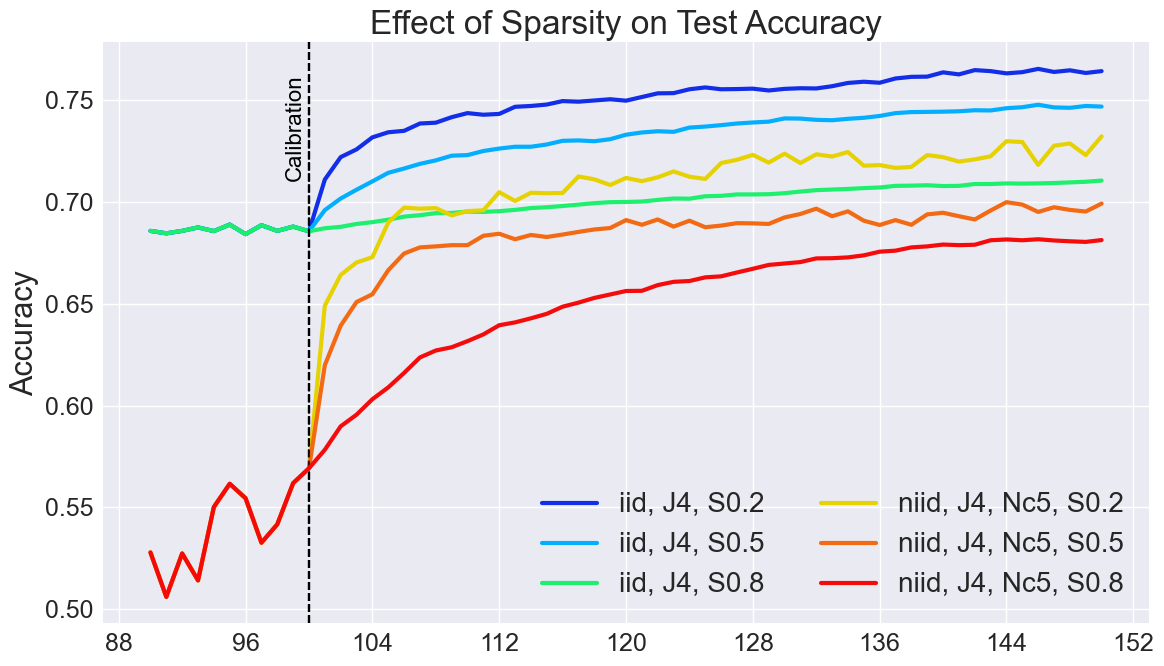

In [ ]:
json_files = [
    ("results_FL_HEAD_iid_J4_NcNone.json", "results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.2_1e4_100.json"),
    ("results_FL_HEAD_iid_J4_NcNone.json", "results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_1e4_100.json"),
    ("results_FL_HEAD_iid_J4_NcNone.json", "results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.8_1e4_100.json"),
    ("results_FL_HEAD_niid_J4_Nc5.json", "results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.2_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc5.json", "results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc5.json", "results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.8_1e4.json")


]

# Labels
labels = [
    "iid, J4, S0.2",
    "iid, J4, S0.5",
    "iid, J4, S0.8",
    "niid, J4, Nc5, S0.2",
    "niid, J4, Nc5, S0.5",
    "niid, J4, Nc5, S0.8"
]

colors = [
    "#0f2ce8",
    "#00aeff",
    "#1BF06C",
    "#e6d200",
    "#f36811",
    "#f50909"
]


plt.figure(figsize=(12,7))

for idx, (head_file, ft_file) in enumerate(json_files):

    with open(head_file, "r") as f:
        head_data = json.load(f)    # Load head training accuracies
    head_accs = head_data.get("test_accuracies", [])[-11:]   # last 10 epochs

    with open(ft_file, "r") as f:
        ft_data = json.load(f)   # Load fine-tuning accuracies
    ft_accs = ft_data.get("test_accuracies", [])

    if "iid" in head_file:
        ft_accs = ft_accs[:50]   # to ensure equal length

    # Concatenate head (10 epoche) + fine-tuning
    combined_accs = head_accs + ft_accs
    x_head = list(range(90, 100+1))
    x_ft   = list(range(101, 101 + len(ft_accs)))
    x_tot = x_head + x_ft
    plt.axvline(x=100, color="black", linestyle="--", linewidth=1.5, alpha=0.8)   # calibration
    plt.plot(x_tot, combined_accs, label=labels[idx], marker='x', color=colors[idx], alpha=0.99)   #, marker=markers[idx]

# calibraiton text
plt.text(
    100-1.5,
    plt.ylim()[1]*0.98,
    "Calibration",
    rotation=90,
    color="black",
    fontsize=16,
    va="top"

)


# --- SETTINGS ---
plt.title("Effect of Sparsity on Test Accuracy")
plt.ylabel("Accuracy")
plt.legend(
    fontsize=20,
    ncol=2,
    frameon=False
)

plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()




In [ ]:
# === Only fine-tuned JSON files ===
json_files = [
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.2_1e4_100.json", "iid, J4, S0.2"),
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_1e4_100.json", "iid, J4, S0.5"),
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.8_1e4_100.json", "iid, J4, S0.8"),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.2_1e4.json", "niid, J4, Nc5, S0.2"),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_1e4.json", "niid, J4, Nc5, S0.5"),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.8_1e4.json", "niid, J4, Nc5, S0.8")
]

summary_data = []

for file, label in json_files:
    with open(file, "r") as f:
        data = json.load(f)

    accuracies = data.get("test_accuracies", [])
    losses = data.get("test_losses", [])
    time_sec = data.get("training_time_sec", None)
    calib_time = data.get("c_time", 0)

    if "_iid_" in file:
        accuracies = accuracies[:50]    # To ensure equal length
        losses = losses[:50]

        if time_sec is not None:
            pure_training = time_sec - calib_time
            time_sec = pure_training / 2 + calib_time

    # Find best accuracy and corresponding epoch
    if accuracies:
        best_acc = max(accuracies)
        best_epoch = accuracies.index(best_acc) + 1   # epochs start from 1
        loss_at_best_acc = losses[best_epoch - 1] if losses else None
    else:
        best_acc = None
        best_epoch = None
        loss_at_best_acc = None

    summary_data.append({
        "Scenario": label,
        "Best Accuracy": best_acc,
        "Epoch of Best Accuracy": best_epoch,
        "Loss at Best Accuracy": loss_at_best_acc,
        "Training Time (s)": time_sec,
        "Calibration Time (s)": calib_time
    })

# Convert to DataFrame
df_summary = pd.DataFrame(summary_data)
df_summary["Pure Training Time (s)"] = df_summary["Training Time (s)"] - df_summary["Calibration Time (s)"]

df_summary


,Scenario,Best Accuracy,Epoch of Best Accuracy,Loss at Best Accuracy,Training Time (s),Calibration Time (s),Pure Training Time (s)
0,"iid, J4, S0.2",0.7652,46,0.855146,2637.40,943.05,1694.35
1,"iid, J4, S0.5",0.7476,46,0.900601,2483.00,798.76,1684.24
2,"iid, J4, S0.8",0.7104,50,1.027185,2243.21,604.83,1638.38
3,"niid, J4, Nc5, S0.2",0.7321,50,1.272222,2555.71,921.31,1634.40
4,"niid, J4, Nc5, S0.5",0.6998,44,1.306760,2420.16,778.32,1641.84
5,"niid, J4, Nc5, S0.8",0.6816,46,1.767597,2266.05,610.33,1655.72


## Calibration rounds

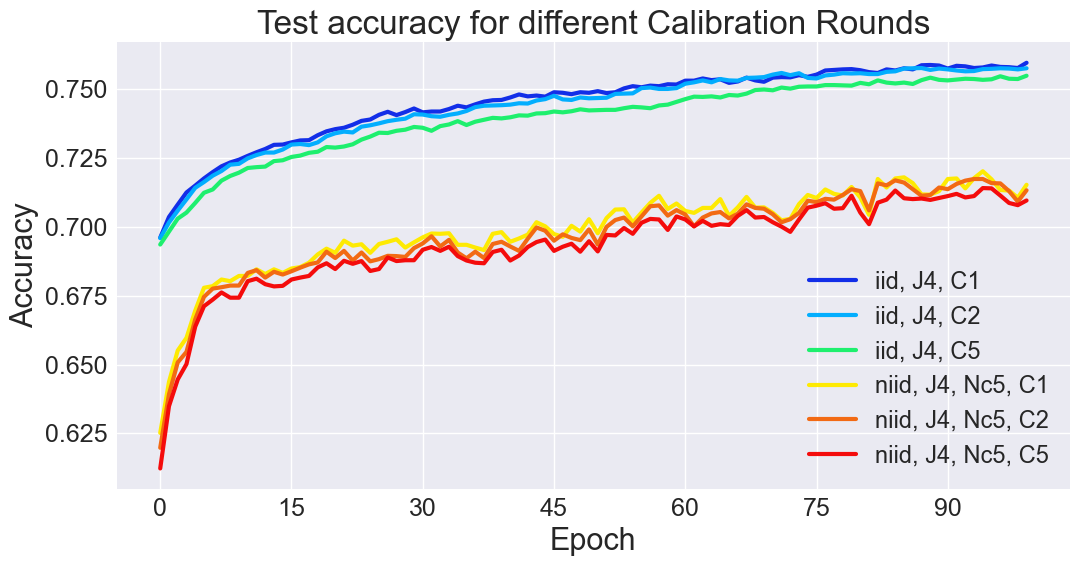

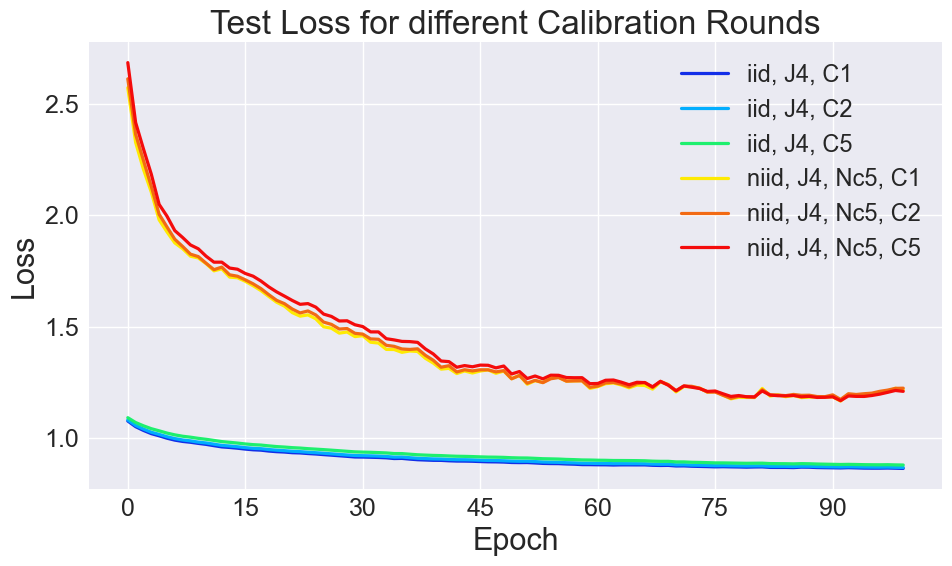

In [ ]:
json_files = [
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal1_S0.5_1e4_100.json",),
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_1e4_100.json",),
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal5_S0.5_1e4_100.json",),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal1_S0.5_1e4_100.json",),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_1e4_100.json",),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal5_S0.5_1e4_100.json",)


]

# Labels
labels = [
    "iid, J4, C1",
    "iid, J4, C2",
    "iid, J4, C5",
    "niid, J4, Nc5, C1",
    "niid, J4, Nc5, C2",
    "niid, J4, Nc5, C5"
]

colors = [
    "#0f2ce8",
    "#00aeff",
    "#1BF06C",
    "#ffea00",
    "#f36811",
    "#f50909"
]

# --- Plot Accuracy ---
plt.figure(figsize=(11,6))

for idx, ft_file_tuple in enumerate(json_files):
    ft_file = ft_file_tuple[0]

    # Load backbone accuracies
    with open(ft_file, "r") as f:
        ft_data = json.load(f)
    backbone_accs = ft_data.get("test_accuracies", [])

    x_axis = list(range(100))
    plt.plot(x_axis, backbone_accs, label=labels[idx], marker='x', color=colors[idx], alpha=0.99)

plt.title("Test accuracy for different Calibration Rounds")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(fontsize=17, ncol=1, frameon=False)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

# --- Plot Loss ---
plt.figure(figsize=(10,6))

for idx, ft_file_tuple in enumerate(json_files):
    ft_file = ft_file_tuple[0]

    # Load backbone losses
    with open(ft_file, "r") as f:
        ft_data = json.load(f)
    backbone_loss = ft_data.get("test_losses", [])

    x_axis = list(range(100))
    plt.plot(x_axis, backbone_loss, label=labels[idx], marker='x', color=colors[idx], alpha=0.99, linewidth=2.31)

plt.title("Test Loss for different Calibration Rounds")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize=17, ncol=1, frameon=False)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()



In [ ]:
json_files = [
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal1_S0.5_1e4_100.json", "iid, J4, C1"),
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_1e4_100.json", "iid, J4, C2"),
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal5_S0.5_1e4_100.json", "iid, J4, C5"),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal1_S0.5_1e4_100.json", "niid, J4, Nc5, C1"),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_1e4_100.json", "niid, J4, Nc5, C2"),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal5_S0.5_1e4_100.json", "niid, J4, Nc5, C5")
]

summary_data = []

for file, label in json_files:
    with open(file, "r") as f:
        data = json.load(f)

    accuracies = data.get("test_accuracies", [])
    losses = data.get("test_losses", [])
    training_time = data.get("training_time_sec", 0)
    calib_time = data.get("c_time", 0)

    # Find best accuracy and corresponding epoch
    if accuracies:
        best_acc = max(accuracies)
        best_epoch = accuracies.index(best_acc) + 1  # epochs start from 1
        loss_at_best_acc = losses[best_epoch - 1] if losses else None
    else:
        best_acc = None
        best_epoch = None
        loss_at_best_acc = None

    # Separate pure training time from calibration
    pure_training = training_time - calib_time
    total_time = pure_training + calib_time

    summary_data.append({
        "Scenario": label,
        "Best Accuracy": best_acc,
        "Epoch of Best Accuracy": best_epoch,
        "Loss at Best Accuracy": loss_at_best_acc,
        "Calibration Time (s)": calib_time,
        "Training Time (s)": pure_training,
        "Total Time (s)": total_time
    })

# Convert to DataFrame
df_summary = pd.DataFrame(summary_data)
df_summary


,Scenario,Best Accuracy,Epoch of Best Accuracy,Loss at Best Accuracy,Calibration Time (s),Training Time (s),Total Time (s)
0,"iid, J4, C1",0.7596,100,0.863658,361.64,3309.38,3671.02
1,"iid, J4, C2",0.7577,88,0.873425,798.76,3368.48,4167.24
2,"iid, J4, C5",0.7549,100,0.878967,2100.96,3359.32,5460.28
3,"niid, J4, Nc5, C1",0.7202,95,1.187395,369.47,3378.00,3747.47
4,"niid, J4, Nc5, C2",0.7174,94,1.195682,797.58,3340.96,4138.54
5,"niid, J4, Nc5, C5",0.7141,95,1.186973,2209.29,3491.06,5700.35


# Different selection methods

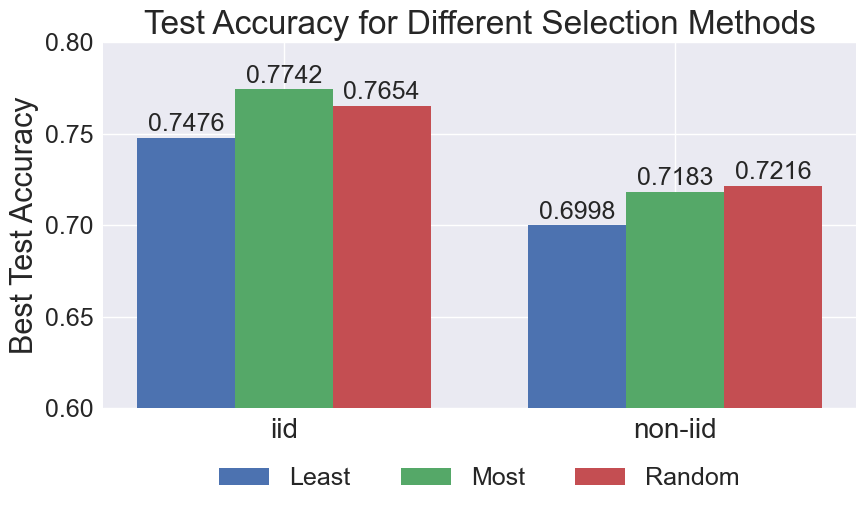

In [ ]:
json_files = [
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_1e4.json", "Least", "iid"),
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_1e4_most.json", "Most", "iid"),
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_1e4_random.json", "Random", "iid"),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_1e4.json", "Least", "non-iid"),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_1e4_most.json", "Most", "non-iid"),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_1e4_random.json", "Random", "non-iid")
]

summary_data = []

for file, scenario_type, group in json_files:
    with open(file, "r") as f:
        data = json.load(f)
    accuracies = data.get("test_accuracies", [])
    best_acc = max(accuracies) if accuracies else None
    summary_data.append({
        "Group": group,
        "Scenario": scenario_type,
        "Best Accuracy": best_acc
    })

df_summary = pd.DataFrame(summary_data)

# === Prepare bar positions for grouped barplot ===
groups = ["iid", "non-iid"]
scenarios = ["Least", "Most", "Random"]
n_scenarios = len(scenarios)
width = 0.25  # width of each bar

x = np.arange(len(groups))  # positions for groups

fig, ax = plt.subplots(figsize=(9,5.5))

bars = []

# Plot bars for each scenario inside each group
for i, scenario in enumerate(scenarios):
    vals = []
    for g in groups:
        val = df_summary[(df_summary["Group"]==g) & (df_summary["Scenario"]==scenario)]["Best Accuracy"].values[0]
        vals.append(val)
    bar = ax.bar(x + (i - 1) * width, vals, width, label=scenario)
    bars.append(bar)

# Add text labels above each bar
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.001, f'{height:.4}',
                ha='center', va='bottom', fontsize=18)

ax.set_xticks(x)
ax.set_xticklabels(groups,fontsize=20)
ax.set_ylabel("Best Test Accuracy")
ax.set_ylim(0.6, 0.8)
ax.set_title("Test Accuracy for Different Selection Methods")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
          ncol=3, frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
json_files = [
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_1e4.json", "Least", "iid"),
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_1e4_most.json", "Most", "iid"),
    ("results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_1e4_random.json", "Random", "iid"),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_1e4.json", "Least", "non-iid"),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_1e4_most.json", "Most", "non-iid"),
    ("results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_1e4_random.json", "Random", "non-iid")
]

summary_data = []

for file, scenario_type, group in json_files:
    with open(file, "r") as f:
        data = json.load(f)

    accuracies = data.get("test_accuracies", [])
    losses = data.get("test_losses", [])

    if accuracies:
        best_idx = int(np.argmax(accuracies))  # index relative to the best accuracy
        best_acc = accuracies[best_idx]
        corresponding_loss = losses[best_idx] if losses else None
        epoch_best_acc = best_idx + 1  # epochs start from 1
    else:
        best_acc = None
        corresponding_loss = None
        epoch_best_acc = None

    summary_data.append({
        "Group": group,
        "Scenario": scenario_type,
        "Best Accuracy": best_acc,
        "Epoch of Best Accuracy": epoch_best_acc,
        "Loss at Best Accuracy": corresponding_loss
    })

df_summary = pd.DataFrame(summary_data)
df_summary


,Group,Scenario,Best Accuracy,Epoch of Best Accuracy,Loss at Best Accuracy
0,iid,Least,0.7476,46,0.900601
1,iid,Most,0.7742,45,0.826575
2,iid,Random,0.7654,46,0.846251
3,non-iid,Least,0.6998,44,1.306760
4,non-iid,Most,0.7183,50,1.085551
5,non-iid,Random,0.7216,50,1.103901
